In [1]:
# Importing Necessary Libraries

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import time

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

In [2]:
# Checking for GPUs
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computational Device is : {device}")

CUDA is available. Number of GPUs: 1
GPU 0: NVIDIA GeForce GTX 1650
Computational Device is : cuda


In [ ]:
# # Define a simple transform to convert images to tensors
# transform = transforms.Compose([
#     transforms.Resize(256),  # Resize to a consistent size
#     transforms.CenterCrop(227),  # Crop to a consistent size
#     transforms.ToTensor()
# ])

# # Get the current working directory
# current_directory = os.getcwd()

# # Load the Caltech 256 dataset
# dataset_dir = os.path.join(current_directory, "Caltech_256/256_ObjectCategories")
# dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
# loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# # Initialize variables to accumulate sum and sum of squares
# mean = torch.zeros(3)
# std = torch.zeros(3)
# n_images = 0

# # Iterate over the dataset
# for images, _ in loader:
#     n_images += images.size(0)  # Update the number of images
#     mean += images.mean([0, 2, 3]) * images.size(0)  # Sum of means for each channel
#     std += images.std([0, 2, 3]) * images.size(0)  # Sum of stds for each channel

# # Divide by the total number of images to get the mean and std
# mean /= n_images
# std /= n_images

# print(f"Mean: {mean}")
# print(f"Std: {std}")


In [3]:
batch_size = 64  # As per the paper (128)

# Define data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # The mean and standard deviation are widely used values for Normalizing images
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # The mean and std were originally derived from the ImageNet Dataset for training Deep Learning Models
])

# Get the current working directory
current_directory = os.getcwd()

# Load the datasets with respective transforms
dataset_dir = os.path.join(current_directory, "Caltech_256/256_ObjectCategories")
train_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=dataset_dir, transform=val_transform)

# Split the dataset into training and validation sets
# Shuffle the indices
indices = np.arange(len(train_dataset))
train_indices, val_indices = train_test_split(indices, test_size=0.15, stratify=np.array(train_dataset.targets))

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4, pin_memory=True)

# Print the number of images in training and validation sets
print("# Dataset Summary")
print("-----")
print(f"Training set: {len(train_loader.sampler.indices)} images, {len(train_loader.dataset.classes)} classes")
print(f"Validation set: {len(val_loader.sampler.indices)} images, {len(val_loader.dataset.classes)} classes")
print("-----")

# Optionally, print class names for reference
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Dataset Summary
-----
Training set: 26015 images, 257 classes
Validation set: 4592 images, 257 classes
-----
Classes: ['airplanes-101', 'ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-side-101', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'clutter', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'el

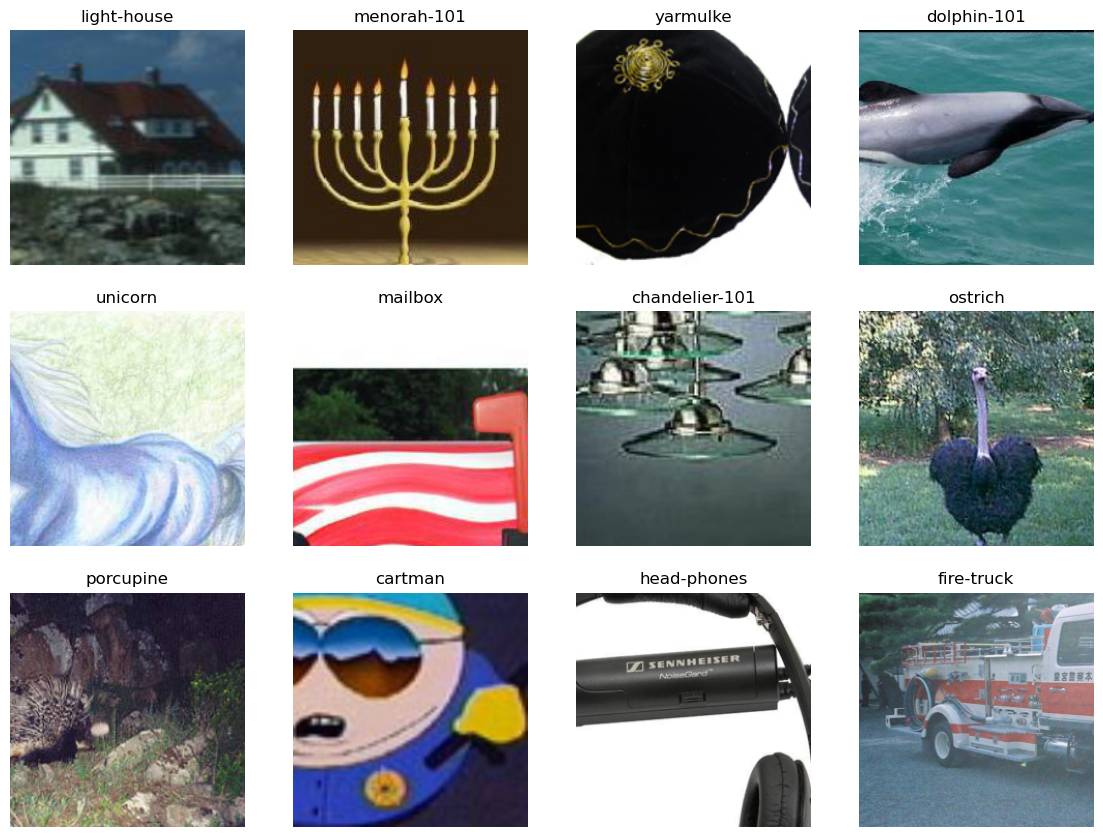

In [4]:
# Function to plot images
def plot_images_from_loader(loader, num_images=12):
    # Retrieve a batch of images and labels
    images, labels = next(iter(loader))
    
    # Unnormalize the images (inverse of normalization)
    inv_transform = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    # Apply the inverse normalization
    images = torch.stack([inv_transform(img) for img in images])
    
    # Define the class names
    class_names = loader.dataset.classes
    
    # Plot the images
    plt.figure(figsize=(14, 14))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert from tensor format to HWC format
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    
    plt.show()

# Plot 12 random images from the training loader
plot_images_from_loader(train_loader, num_images=12)

In [10]:
# Define the custom LocalResponseNormalization layer
class LocalResponseNorm(nn.Module):
    def __init__(self, depth_radius=2, bias=2.0, alpha=1e-4, beta=0.75):
        super(LocalResponseNorm, self).__init__()
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        return F.local_response_norm(x, self.depth_radius, self.alpha, self.beta, self.bias)

# Define the AlexNet model as a subclass of nn.Module
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.lrn1 = LocalResponseNorm()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.lrn2 = LocalResponseNorm()
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        
        # Fifth convolutional layer
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Flatten the tensor to prepare for the fully connected layers
        self.flatten = nn.Flatten()
        
        # First fully-connected layer with dropout
        self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
        self.dropout1 = nn.Dropout(p=0.5)
        
        # Second fully-connected layer with dropout
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.dropout2 = nn.Dropout(p=0.5)
        
        # Third fully-connected layer / Output layer with softmax activation
        self.fc3 = nn.Linear(in_features=4096, out_features=num_classes)

    # Define the forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU activation after the first convolution
        x = self.lrn1(x)  # Apply Local Response Normalization
        x = self.pool1(x)  # Apply max pooling
        
        x = F.relu(self.conv2(x))  # Apply ReLU activation after the second convolution
        x = self.lrn2(x)  # Apply Local Response Normalization
        x = self.pool2(x)  # Apply max pooling
        
        x = F.relu(self.conv3(x))  # Apply ReLU activation after the third convolution
        
        x = F.relu(self.conv4(x))  # Apply ReLU activation after the fourth convolution
        
        x = F.relu(self.conv5(x))  # Apply ReLU activation after the fifth convolution
        x = self.pool3(x)  # Apply max pooling
        
        x = self.flatten(x)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully-connected layer
        x = self.dropout1(x)  # Apply dropout
        
        x = F.relu(self.fc2(x))  # Apply ReLU activation after the second fully-connected layer
        x = self.dropout2(x)  # Apply dropout
        
        x = self.fc3(x)  # Output layer with softmax activation (applied externally)
        
        return x
        

In [11]:
# Instantiate the model and move it to the device
alexnet_model = AlexNet(num_classes=1000).to(device)

# Print model summary
summary(alexnet_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
 LocalResponseNorm-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
 LocalResponseNorm-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
            Conv2d-8          [-1, 384, 13, 13]       1,327,488
            Conv2d-9          [-1, 256, 13, 13]         884,992
        MaxPool2d-10            [-1, 256, 6, 6]               0
          Flatten-11                 [-1, 9216]               0
           Linear-12                 [-1, 4096]      37,752,832
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
# Model parameters
input_shape = (3, 227, 227)
num_classes = len(train_loader.dataset.classes) 
batch_size = 64 # as per paper said (128)
epochs = 2  # as per paper said (90)

# Define model, loss function, optimizer, and learning rate scheduler
model = AlexNet(num_classes=num_classes).to(device)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=5, verbose=True, min_lr=1e-5)

# Define metrics
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Training function with optimizations
def train_model(model, criterion, optimizer, scheduler, num_epochs=45):
    start_time = time.time()

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_top1_acc': [],
        'val_top1_acc': [],
        'train_top5_acc': [],
        'val_top5_acc': []
    }

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        training_time_ep = 0
        start_time_ep = time.time()
        model.train()
        train_loss = 0.0
        train_top1_correct = 0
        train_top5_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
            train_top1_correct += acc1.item() * inputs.size(0) / 100.0
            train_top5_correct += acc5.item() * inputs.size(0) / 100.0
            total += labels.size(0)

        train_loss /= len(train_loader.sampler)
        train_top1_acc = train_top1_correct / total
        train_top5_acc = train_top5_correct / total

        history['train_loss'].append(train_loss)
        history['train_top1_acc'].append(train_top1_acc)
        history['train_top5_acc'].append(train_top5_acc)

        model.eval()
        val_loss = 0.0
        val_top1_correct = 0
        val_top5_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
                val_top1_correct += acc1.item() * inputs.size(0) / 100.0
                val_top5_correct += acc5.item() * inputs.size(0) / 100.0
                val_total += labels.size(0)

        val_loss /= len(val_loader.sampler)
        val_top1_acc = val_top1_correct / val_total
        val_top5_acc = val_top5_correct / val_total

        history['val_loss'].append(val_loss)
        history['val_top1_acc'].append(val_top1_acc)
        history['val_top5_acc'].append(val_top5_acc)
        end_time_ep = time.time()
        training_time_ep = end_time_ep - start_time_ep
        print(f"Epoch {epoch + 1}/{num_epochs}, Time elapsed: {(training_time_ep/60):.2f} mins \n"
              f"Train Loss: {history['train_loss'][-1]:.4f}, Train Top-1 Acc: {history['train_top1_acc'][-1]:.4f}, Train Top-5 Acc: {history['train_top5_acc'][-1]:.4f} | "
              f"Val Loss: {history['val_loss'][-1]:.4f}, Val Top-1 Acc: {history['val_top1_acc'][-1]:.4f}, Val Top-5 Acc: {history['val_top5_acc'][-1]:.4f}")

        scheduler.step(val_top1_acc)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nTraining time: {(training_time/60):.2f} mins")

    return history

# Train the model
history = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=2)

# Print the model summary
summary(model, input_size=(3, 227, 227))

In [ ]:
# Function to plot training and validation metrics
def plot_metrics(history):
    # Create subplots for accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history['train_top1_acc'], label='Train Top-1 Accuracy')
    ax1.plot(history['val_top1_acc'], label='Validation Top-1 Accuracy')
    ax1.set_title('Model Top-1 Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Compute error rates for the final epoch
    final_epoch = len(history['train_top1_acc']) - 1
    train_top1_error = (1 - history['train_top1_acc'][final_epoch]) * 100
    val_top1_error = (1 - history['val_top1_acc'][final_epoch]) * 100
    train_top5_error = (1 - history['train_top5_acc'][final_epoch]) * 100
    val_top5_error = (1 - history['val_top5_acc'][final_epoch]) * 100

    # Create a table to display the error rates for the final epoch in percentage
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    table_data = [
        ["Metric", "Error Rate (%)"],
        ["Train Top-1 Error", f"{train_top1_error:.2f}"],
        ["Validation Top-1 Error", f"{val_top1_error:.2f}"],
        ["Train Top-5 Error", f"{train_top5_error:.2f}"],
        ["Validation Top-5 Error", f"{val_top5_error:.2f}"]
    ]

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.show()

# Plot the accuracy, loss curves, and error rate table
plot_metrics(history)